In [26]:
import numpy as np
import math
import scipy.io as sio
import matplotlib.pyplot as plt
import torch.utils.data
from sklearn.model_selection import train_test_split
from beam_utils import UPA_DFT_codebook, pow_2_dB, dB_2_pow
import torch
from DL_utils import Joint_BF_Classifier,Joint_BF_Autoencoder,eval_model
import DeepMIMO
from os.path import exists
import pandas

### Experiment settings: default parameters

In [27]:
# Default parameters
n_probing_beam = None # defaul number of probing beams
noise_power_dBm = -81 # noise power dBm
measurement_gain = 16.0 # spreading gain of probing measurements
measurement_gain_dB = 10*np.log10(measurement_gain)
gamma = 0.3 # trade-off between BF loss and misdetection loss
h_NMSE_dB = -np.inf # channel NMSE in dB, to generate noisy training data
IA_threshold = -5 # initial access SNR threshold in dB
random_UE_rotation = True

### Specify DeepMIMO scenario and generate channel matrices

In [28]:
scenario = 'O1_28' # DeepMIMO Ray-tracing scenario
activated_BS = 3 # Index of activated BS in the scenario
random_UE_rotation = True # True: UE rotation is random, False: UE rotation is fixed
array_type = 'UPA' # BS and UE array type, ULA or UPA

# Set the BS transmit power in dBm
if scenario == 'O1_28':
    tx_power_dBm = 20
elif scenario == 'O1_28B':
    tx_power_dBm = 35    
elif scenario == 'I3_60':
    if activated_BS==1:
        tx_power_dBm = 15
    elif activated_BS==2:
        tx_power_dBm = 20
    else:
        raise Exception("Unsupported BS activation!") 
else:
    raise Exception("Unsupported Ray-Tracing Scenario!")

# UE grid depending on the scenario
if scenario == 'O1_28':
    BS_arr = np.array([3])
    ue_row_first = 800
    ue_row_last = 1200
elif scenario == 'O1_28B':
    BS_arr = np.array([3])
    ue_row_first = 1
    ue_row_last = 2751    
elif scenario == 'I3_60':
    BS_arr = np.array([activated_BS])
    ue_row_first = 1
    ue_row_last = 1159
else:
    raise Exception("Unsupported Ray-Tracing Scenario!")

# Generate the DeepMIMO dataset
parameters = DeepMIMO.default_params()
parameters['dataset_folder'] = 'D:/Github Repositories/DeepMIMO-codes/DeepMIMOv2/Raytracing_scenarios' # replace with your DeepMIMO dataset folder

parameters['scenario'] = scenario
parameters['num_paths'] = 25
parameters['active_BS'] = BS_arr
parameters['user_row_first'] = ue_row_first
parameters['user_row_last'] = ue_row_last
parameters['row_subsampling'] = 1
parameters['user_subsampling'] = 1

parameters['bs_antenna']['shape'] = np.array([1, 8, 8])
parameters['bs_antenna']['spacing'] = 0.5
parameters['bs_antenna']['radiation_pattern'] = 'isotropic'

parameters['ue_antenna']['shape'] = np.array([1, 4, 4])
parameters['ue_antenna']['spacing'] = 0.5
if random_UE_rotation:
    parameters['ue_antenna']['rotation'] = np.array([[-180,180],[-90,90],[-90,90]])
parameters['ue_antenna']['radiation_pattern'] = 'isotropic'

parameters['enable_BS2BS'] = 0

parameters['OFDM_channels'] = 1 # Frequency (OFDM) or time domain channels
parameters['OFDM']['subcarriers'] = 512
parameters['OFDM']['subcarriers_limit'] = 1
parameters['OFDM']['subcarriers_sampling'] = 1
parameters['OFDM']['bandwidth'] = 0.1
parameters['OFDM']['RX_filter'] = 0

dataset = DeepMIMO.generate_data(parameters)
h = dataset[0]['user']['channel'].squeeze()

eigen_bf_gain_path = './Data/eigen_bf_gain_{}_BS_{}_BS_array_{}x{}x{}_UE_array_{}x{}x{}.npy'.format(parameters['scenario'],parameters['active_BS'][0],
                                                                                        parameters['bs_antenna'][0]['shape'][0],parameters['bs_antenna'][0]['shape'][1],parameters['bs_antenna'][0]['shape'][2],
                                                                                        parameters['ue_antenna']['shape'][0],parameters['ue_antenna']['shape'][1],parameters['ue_antenna']['shape'][2])
if exists(eigen_bf_gain_path):
    eigen_bf_gain = np.load(eigen_bf_gain_path,allow_pickle=True)
else:
    eigen_bf_gain = np.linalg.eigvalsh(np.transpose(h.conj(),axes=(0,2,1)) @ h)[:,-1] # compute the max eigenvalue of the channel covariance matrix, this is the uppero bound of the BF gain
    np.save(eigen_bf_gain_path,eigen_bf_gain,allow_pickle=True)
eigen_snr = tx_power_dBm+10*np.log10(eigen_bf_gain)-noise_power_dBm # SNR with eigen beamforming
reachable_ue = eigen_snr>IA_threshold   # remove UEs that are impossible to complete IA with eigen beamforming
print('Removed {} out of {} UEs that are below the IA SNR threshold ({} dB).'.format((~reachable_ue).sum(),h.shape[0],IA_threshold))    
h = h[reachable_ue]

norm_factor = np.max(abs(h))
h_scaled = (h.T/norm_factor).T


Basestation 3



UE-BS Channels


Generating channels: 100%|██████████| 72581/72581 [00:19<00:00, 3756.75it/s]


Removed 0 out of 72581 UEs that are below the IA SNR threshold (-5 dB).


### Training and testing data partition

In [29]:
# Training and testing data:
# --------------------------
train_idc, test_idc = train_test_split(np.arange(h.shape[0]),test_size=0.4,random_state=7)
val_idc, test_idc = train_test_split(test_idc,test_size=0.5,random_state=7)
num_antenna_Tx = np.prod(parameters['bs_antenna'][0]['shape'])
num_antenna_Rx = np.prod(parameters['ue_antenna']['shape'])

x_test = h_scaled[test_idc]
torch_x_test = torch.from_numpy(x_test)

## Baselines: Exhaustive search, MRT+MRC, DFT+EGC, genie+DFT

In [30]:
snr_baselines = {}
    
DFT_codebook_TX = UPA_DFT_codebook(n_azimuth=8*2,n_elevation=8*2,n_antenna_azimuth=8,n_antenna_elevation=8,spacing=0.5).T
DFT_codebook_RX = UPA_DFT_codebook(n_azimuth=4*2,n_elevation=4*2,n_antenna_azimuth=4,n_antenna_elevation=4,spacing=0.5).T

MRT_MRC_gain = np.linalg.eigvalsh(np.transpose(h[test_idc].conj(),axes=(0,2,1)) @ h[test_idc])[:,-1]
DFT_EGC_gain = np.max(np.power(np.sum(abs(h[test_idc] @ DFT_codebook_TX),axis=-2),2)/num_antenna_Rx,axis=-1)
EGT_DFT_gain = np.max(np.power(np.sum(abs(DFT_codebook_RX.conj().T @ h[test_idc]),axis=-1),2)/num_antenna_Tx,axis=-1)    

"""    
compute exhaustive beam search snr
"""
dft_rx_bf_signal = h[test_idc] @ DFT_codebook_TX
dft_bf_signal_wo_noise = DFT_codebook_RX.conj().T @ dft_rx_bf_signal
dft_bf_gain_wo_noise =  np.power(np.absolute(dft_bf_signal_wo_noise),2)
DFT_genie_gain = dft_bf_gain_wo_noise.max(axis=(-1,-2))

eval_noise_power = 10**((noise_power_dBm-tx_power_dBm)/10)/measurement_gain # SNR
rx_noise_real = np.random.normal(loc=0,scale=1,size=dft_rx_bf_signal.shape)*np.sqrt(eval_noise_power/2)
rx_noise_imag = np.random.normal(loc=0,scale=1,size=dft_rx_bf_signal.shape)*np.sqrt(eval_noise_power/2)
dft_rx_bf_signal_w_noise = dft_rx_bf_signal + rx_noise_real + 1j*rx_noise_imag
dft_bf_signal_w_noise = DFT_codebook_RX.conj().T @ dft_rx_bf_signal_w_noise
dft_bf_gain_w_noise =  np.power(np.absolute(dft_bf_signal_w_noise),2)
optimal_beam_pair_exhaustive = dft_bf_gain_w_noise.reshape(dft_bf_gain_w_noise.shape[0],-1).argmax(axis=-1)
bf_gain_exhaustive = dft_bf_gain_wo_noise.reshape(dft_bf_gain_wo_noise.shape[0],-1)[np.arange(dft_bf_gain_wo_noise.shape[0]),optimal_beam_pair_exhaustive]

snr_baselines['genie_DFT'] = tx_power_dBm + 10*np.log10(DFT_genie_gain) - noise_power_dBm
snr_baselines['exhaustive'] = tx_power_dBm + 10*np.log10(bf_gain_exhaustive) - noise_power_dBm
snr_baselines['MRT_MRC'] = tx_power_dBm + 10*np.log10(MRT_MRC_gain) - noise_power_dBm
snr_baselines['DFT_EGC'] = tx_power_dBm + 10*np.log10(DFT_EGC_gain) - noise_power_dBm
snr_baselines['EGT_DFT'] = tx_power_dBm + 10*np.log10(EGT_DFT_gain) - noise_power_dBm

# np.save('./Data/snr_baselines_{}_BS_{}.npy'.format(scenario,BS_arr[0]),snr_baselines,allow_pickle=True)

# snr_baselines = np.load('./Data/snr_baselines_{}_BS_{}.npy'.format(scenario,BS_arr[0]),allow_pickle=True).item()

tabular_results = []
for pctl in [10,50,90]:
    row = ['{}th %'.format(pctl),
            np.percentile(snr_baselines['exhaustive'],pctl),
            np.percentile(snr_baselines['genie_DFT'],pctl),
            np.percentile(snr_baselines['DFT_EGC'],pctl),
            np.percentile(snr_baselines['MRT_MRC'],pctl)]
    tabular_results.append(row)
row = ["avg.",
        pow_2_dB(dB_2_pow(snr_baselines['exhaustive']).mean()),
        pow_2_dB(dB_2_pow(snr_baselines['genie_DFT']).mean()),
        pow_2_dB(dB_2_pow(snr_baselines['DFT_EGC']).mean()),
        pow_2_dB(dB_2_pow(snr_baselines['MRT_MRC']).mean())]
tabular_results.append(row)
headers=["SNR (dB)", "Exhaustive", "Genie+DFT", "DFT+EGC","MRT+MRC"]
with pandas.option_context('display.float_format', '{:0.3f}'.format):
    print(pandas.DataFrame(tabular_results, columns=headers))

  SNR (dB)  Exhaustive  Genie+DFT  DFT+EGC  MRT+MRC
0   10th %      10.649     10.835   11.744   12.421
1   50th %      15.318     15.365   16.217   16.707
2   90th %      19.715     19.723   20.517   20.918
3     avg.      16.597     16.634   17.440   17.949


## Load All Models for vs. $N_{probe}$ Plots

In [31]:
n_probing_beam = None # defaul number of probing beams
noise_power_dBm = -81 # noise power dBm
measurement_gain = 16.0 # spreading gain of probing measurements
gamma = 0.3 # trade-off between BF loss and misdetection loss
h_NMSE_dB = -np.inf # channel NMSE in dB, to generate noisy training data
IA_threshold = -5 # initial access SNR threshold in dB
random_UE_rotation = True
train_noise_power = 10**((noise_power_dBm-tx_power_dBm)/10)/measurement_gain # probing measurements SNR
loss_fn = 'BF_IA_loss'

In [32]:
snr_vs_npb_dict = {}
misdetection_rate_vs_npb_dict = {}
n_pb_dict = {}

# the following are the model parameter combinations to evaluate
# 1. Beam prediction mode: GF: grid-free, CB: codebook-based,
# Beam prediction function: MLP: multi-layer perceptron, CNN: convolutional neural network
# 2. Probing and sensing beams:
# TxRx: jointly learned Tx probing beams and Rx sensing beams, Tx: only Tx probing beams are learned, Rx use DFT beams
# 3. Probing measurements feedback (assuming N probing and sensing beams, the NxN measurement matrix contains all combinations of probing and sensing beams):
# diagonal: only the diagonal elements of the measurement matrxi are fed back, max: the best Rx sensing beam for each probing beam is fed back, full: all elements of the measurement matrix are fed back
# 4. The number of probing measurements to feed back:
# None: all measurements are fed back, otherwise the strongest k measurments are fed back
# 5. gamma: trade-off between BF loss and misdetection loss
model_param_combinations = ['GF_MLP_TxRx_diagonal_None_0.3','GF_MLP_TxRx_max_None_0.3',
                           'GF_MLP_TxRx_full_None_0.3','GF_MLP_TxRx_diagonal_4_0.3',
                           'GF_MLP_TxRx_diagonal_8_0.3','GF_MLP_Tx_diagonal_None_0.3',
                           'GF_MLP_DFT_full_None_1.0','GF_CNN_TxRx_diagonal_None_0.3',
                           'CB_MLP_TxRx_diagonal_None_None','GF_MLP_TxRx_diagonal_None_1.0']
# # a smaller set of combinations for I3 scenarios
# model_param_combinations = ['GF_MLP_TxRx_diagonal_None_0.3','CB_MLP_TxRx_diagonal_None_None',
#                            'GF_MLP_TxRx_diagonal_4_0.3','GF_MLP_TxRx_diagonal_8_0.3',
#                            'GF_MLP_TxRx_diagonal_None_1.0']
model_savefname_prefix = './Models/'

for setup_param in model_param_combinations:
    snr_vs_npb_dict[setup_param] = []
    misdetection_rate_vs_npb_dict[setup_param] = []
    beam_prediction_mode, beam_synthesizer, learned_probing, feedback_mode, num_feedback, gamma = setup_param.split('_')
    n_pb_arr = np.arange(4,49,4) # list of probing beam numbers to evaluate

    if num_feedback == 'None':
        num_feedback = None
    else:
        num_feedback = int(num_feedback)
        n_pb_arr = np.arange(num_feedback+4,49,4)
        
    if feedback_mode != 'diagonal':
        if learned_probing == 'TxRx':
            n_pb_arr = np.arange(2,8)
        else:
            n_pb_arr = np.concatenate((np.arange(2,8),np.arange(8,49,4)))
                
    if beam_synthesizer == 'CNN':
        n_pb_arr = np.arange(8,49,4)
    
    n_pb_dict[setup_param] = n_pb_arr

    for n_probing_beam in n_pb_arr:
        if beam_prediction_mode == 'GF':
            model = Joint_BF_Autoencoder(num_antenna_Tx = num_antenna_Tx, num_antenna_Rx = num_antenna_Rx, 
                                         num_probing_beam_Tx = n_probing_beam, num_probing_beam_Rx = n_probing_beam, 
                                         noise_power=train_noise_power, norm_factor=norm_factor,
                                         feedback=feedback_mode,num_feedback = num_feedback,
                                         learned_probing = learned_probing, beam_synthesizer = beam_synthesizer).cpu()
            gamma = float(gamma)
            loss_fn = 'BF_IA_loss'
        else:
            model = Joint_BF_Classifier(num_antenna_Tx = num_antenna_Tx, num_antenna_Rx = num_antenna_Rx,
                                        num_probing_beam_Tx = n_probing_beam, num_probing_beam_Rx = n_probing_beam, 
                                        num_Tx_beams = int(16*16), num_Rx_beams = int(8*8),
                                        noise_power=train_noise_power, norm_factor=norm_factor).cpu()
            gamma = None 
            loss_fn = 'CE'
        model_setup_params = ("{}_BS_{}_{}_"+
                        "UE_rot_{}_"+
                        "{}_{}_probe_"+
                        "{}_FB_{}_"+
                        "{}_"+
                        "{}_gamma_{}_"+
                        "train_noise_{}_dBm_"+
                        "meas_gain_{}_"+
                        "IA_thresh_{}_"+
                        "h_NMSE_{}").format(parameters['scenario'], parameters['active_BS'][0],beam_prediction_mode,
                                            random_UE_rotation,
                                            n_probing_beam, learned_probing,
                                            feedback_mode, num_feedback,
                                            beam_synthesizer,
                                            loss_fn, gamma,
                                            noise_power_dBm,
                                            measurement_gain,
                                            IA_threshold,
                                            h_NMSE_dB)
        try:
            state_dict_load = torch.load(model_savefname_prefix+model_setup_params+'.pt')
            model.load_state_dict(state_dict_load)
        except FileNotFoundError:
            print(setup_param,n_probing_beam)
        
        predicted_bf_gain, probing_codebook_bf_gain = eval_model(model,torch_x_test,h[test_idc],
                                                                 noise_power=train_noise_power,prediction_mode=beam_prediction_mode,feedback_mode=feedback_mode)
        
        model_snr = tx_power_dBm + 10*np.log10(predicted_bf_gain) - noise_power_dBm
        snr_vs_npb_dict[setup_param].append(model_snr)

        probing_beam_max_snr = tx_power_dBm + 10*np.log10(probing_codebook_bf_gain) - noise_power_dBm
        misdetection_rate_vs_npb_dict[setup_param].append((probing_beam_max_snr<IA_threshold).mean()*100)

    snr_vs_npb_dict[setup_param] = np.array(snr_vs_npb_dict[setup_param])
    misdetection_rate_vs_npb_dict[setup_param] = np.array(misdetection_rate_vs_npb_dict[setup_param])        

e:\Anaconda\envs\p39\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


## Avg. SNR & Misdetection Prob. vs. $N_{probe}$

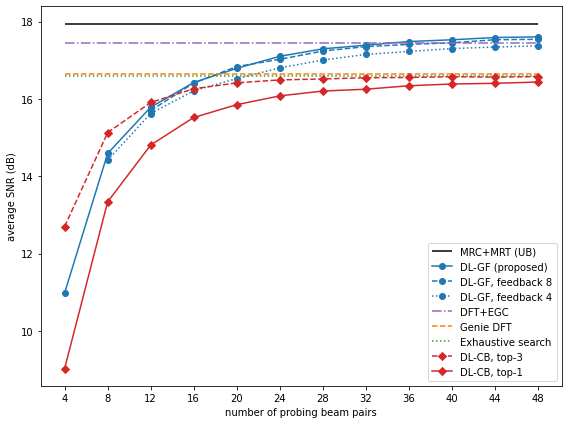

In [33]:
plt.figure(figsize=(8,6))
plt.hlines(y=pow_2_dB(dB_2_pow(snr_baselines['MRT_MRC']).mean()),xmin=4,xmax=48,color='black',linestyles='solid',label='MRC+MRT (UB)')
plt.plot(n_pb_dict['GF_MLP_TxRx_diagonal_None_0.3'], pow_2_dB(dB_2_pow(snr_vs_npb_dict['GF_MLP_TxRx_diagonal_None_0.3']).mean(axis=-1)), color='tab:blue', marker='o',label='DL-GF (proposed)')
plt.plot(n_pb_dict['GF_MLP_TxRx_diagonal_8_0.3'], pow_2_dB(dB_2_pow(snr_vs_npb_dict['GF_MLP_TxRx_diagonal_8_0.3']).mean(axis=-1)), color='tab:blue', linestyle='dashed', marker='o',label='DL-GF, feedback 8')
plt.plot(n_pb_dict['GF_MLP_TxRx_diagonal_4_0.3'], pow_2_dB(dB_2_pow(snr_vs_npb_dict['GF_MLP_TxRx_diagonal_4_0.3']).mean(axis=-1)), color='tab:blue', linestyle='dotted', marker='o',label='DL-GF, feedback 4')
plt.hlines(y=pow_2_dB(dB_2_pow(snr_baselines['DFT_EGC']).mean()),xmin=4,xmax=48,color='tab:purple',linestyles='dashdot',label='DFT+EGC')
plt.hlines(y=pow_2_dB(dB_2_pow(snr_baselines['genie_DFT']).mean()),xmin=4,xmax=48,color='tab:orange',linestyles='dashed',label='Genie DFT')
plt.hlines(y=pow_2_dB(dB_2_pow(snr_baselines['exhaustive']).mean()),xmin=4,xmax=48,color='tab:green',linestyles='dotted',label='Exhaustive search')
plt.plot(n_pb_dict['CB_MLP_TxRx_diagonal_None_None'], pow_2_dB(dB_2_pow(snr_vs_npb_dict['CB_MLP_TxRx_diagonal_None_None'][:,1,:]).mean(axis=-1)), color='tab:red', linestyle='dashed', marker='D',label='DL-CB, top-3')
plt.plot(n_pb_dict['CB_MLP_TxRx_diagonal_None_None'], pow_2_dB(dB_2_pow(snr_vs_npb_dict['CB_MLP_TxRx_diagonal_None_None'][:,0,:]).mean(axis=-1)), color='tab:red', marker='D',label='DL-CB, top-1')
plt.xlabel('number of probing beam pairs')
plt.ylabel('average SNR (dB)')
plt.legend(loc='lower right')
plt.xticks(n_pb_dict['GF_MLP_TxRx_diagonal_None_0.3'])
plt.tight_layout()
plt.show()

In [34]:
tabular_results = []
for num_feedback in [None,8,4]:
    row = list(pow_2_dB(dB_2_pow(snr_vs_npb_dict['GF_MLP_TxRx_diagonal_{}_0.3'.format(num_feedback)]).mean(axis=-1)))
    if num_feedback == 8:
        row.insert(0,None)
        row.insert(0,None)
    if num_feedback == 4:
        row.insert(0,None)
    row.insert(0,num_feedback)
    tabular_results.append(row)
headers= list(n_pb_dict['GF_MLP_TxRx_diagonal_None_0.3'])
headers.insert(0,'num feedback')
with pandas.option_context('display.float_format', '{:0.3f}'.format):
    print(pandas.DataFrame(tabular_results, columns=headers))

   num feedback      4      8     12     16     20     24     28     32  \
0           NaN 10.984 14.591 15.788 16.426 16.793 17.103 17.297 17.392   
1         8.000    NaN    NaN 15.700 16.411 16.838 17.026 17.240 17.355   
2         4.000    NaN 14.418 15.624 16.212 16.528 16.804 17.006 17.153   

      36     40     44     48  
0 17.486 17.531 17.590 17.607  
1 17.412 17.453 17.533 17.544  
2 17.230 17.304 17.344 17.375  


In [35]:
n_pb_arr = np.arange(4,49,4)
n_probing_beam = 32
gamma = 0.3
tabular_results = []
for pctl in [5,10,50,90,95]:
    row = ['{}th %'.format(pctl),np.percentile(snr_vs_npb_dict['GF_MLP_TxRx_diagonal_None_0.3'][n_pb_arr==n_probing_beam],pctl),
           np.percentile(snr_vs_npb_dict['CB_MLP_TxRx_diagonal_None_None'][n_pb_arr==n_probing_beam,1,:],pctl),
           np.percentile(snr_baselines['exhaustive'],pctl),
           np.percentile(snr_baselines['genie_DFT'],pctl),
           np.percentile(snr_baselines['DFT_EGC'],pctl),
           np.percentile(snr_baselines['MRT_MRC'],pctl)]
    tabular_results.append(row)
row = ["avg.",pow_2_dB(dB_2_pow(snr_vs_npb_dict['GF_MLP_TxRx_diagonal_None_0.3'][n_pb_arr==n_probing_beam]).mean()),
       pow_2_dB(dB_2_pow(snr_vs_npb_dict['CB_MLP_TxRx_diagonal_None_None'][n_pb_arr==n_probing_beam,1,:]).mean()),
       pow_2_dB(dB_2_pow(snr_baselines['exhaustive']).mean()),
       pow_2_dB(dB_2_pow(snr_baselines['genie_DFT']).mean()),
       pow_2_dB(dB_2_pow(snr_baselines['DFT_EGC']).mean()),
       pow_2_dB(dB_2_pow(snr_baselines['MRT_MRC']).mean())]
tabular_results.append(row)
print('{} probing beams'.format(n_probing_beam))
print('Misdetection prob: {:.3f}% below -5dB'.format(misdetection_rate_vs_npb_dict['GF_MLP_TxRx_diagonal_None_0.3'][n_pb_arr==n_probing_beam][0]))
headers=["SNR (dB)", "DL-GF", "DL-CB, top3", "Exhaustive", "Genie+DFT", "DFT+EGC","MRT+MRC"]
with pandas.option_context('display.float_format', '{:0.3f}'.format):
    print(pandas.DataFrame(tabular_results, columns=headers))

32 probing beams
Misdetection prob: 0.117% below -5dB
  SNR (dB)  DL-GF  DL-CB, top3  Exhaustive  Genie+DFT  DFT+EGC  MRT+MRC
0    5th %  9.165        9.023       9.198      9.432   10.402   11.046
1   10th % 11.212       10.619      10.649     10.835   11.744   12.421
2   50th % 16.289       15.305      15.318     15.365   16.217   16.707
3   90th % 20.512       19.687      19.715     19.723   20.517   20.918
4   95th % 21.791       20.996      21.065     21.073   21.910   22.366
5     avg. 17.392       16.549      16.597     16.634   17.440   17.949


## Avg. SNR vs. $N_{probe}$ Ablation Study

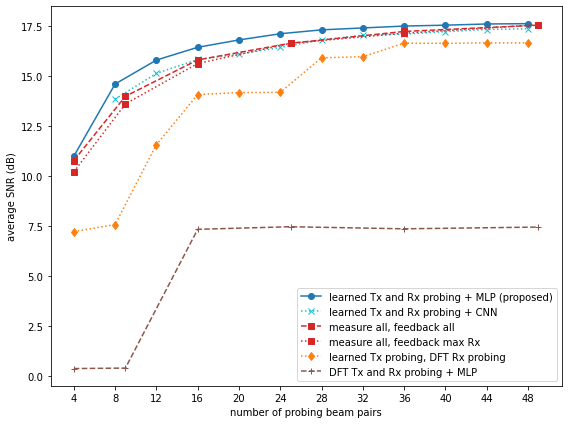

In [36]:
plt.figure(figsize=(8,6))
plt.plot(n_pb_dict['GF_MLP_TxRx_diagonal_None_0.3'], pow_2_dB(dB_2_pow(snr_vs_npb_dict['GF_MLP_TxRx_diagonal_None_0.3']).mean(axis=-1)), color='tab:blue', marker='o',label='learned Tx and Rx probing + MLP (proposed)')
plt.plot(n_pb_dict['GF_CNN_TxRx_diagonal_None_0.3'], pow_2_dB(dB_2_pow(snr_vs_npb_dict['GF_CNN_TxRx_diagonal_None_0.3']).mean(axis=-1)), color='tab:cyan',linestyle='dotted', marker='x',label='learned Tx and Rx probing + CNN')
plt.plot(n_pb_dict['GF_MLP_TxRx_full_None_0.3']**2, pow_2_dB(dB_2_pow(snr_vs_npb_dict['GF_MLP_TxRx_full_None_0.3']).mean(axis=-1)), color='tab:red',linestyle='dashed', marker='s',label='measure all, feedback all')
plt.plot(n_pb_dict['GF_MLP_TxRx_max_None_0.3']**2, pow_2_dB(dB_2_pow(snr_vs_npb_dict['GF_MLP_TxRx_max_None_0.3']).mean(axis=-1)), color='tab:red',linestyle='dotted', marker='s',label='measure all, feedback max Rx')
plt.plot(n_pb_dict['GF_MLP_Tx_diagonal_None_0.3'], pow_2_dB(dB_2_pow(snr_vs_npb_dict['GF_MLP_Tx_diagonal_None_0.3']).mean(axis=-1)), color='tab:orange',linestyle='dotted', marker='d',label='learned Tx probing, DFT Rx probing')
plt.plot(n_pb_dict['GF_MLP_DFT_full_None_1.0'][:6]**2, pow_2_dB(dB_2_pow(snr_vs_npb_dict['GF_MLP_DFT_full_None_1.0'][:6]).mean(axis=-1)), color='tab:brown',linestyle='dashed', marker='+',label='DFT Tx and Rx probing + MLP')
plt.xlabel('number of probing beam pairs')
plt.ylabel('average SNR (dB)')
plt.legend(loc='lower right')
plt.xticks(n_pb_dict['GF_MLP_TxRx_diagonal_None_0.3'])
plt.tight_layout()
plt.show()

## Choosing $\gamma$

In [37]:
n_probing_beam = None # defaul number of probing beams
noise_power_dBm = -81 # noise power dBm
measurement_gain = 16.0 # spreading gain of probing measurements
gamma = 0.3 # trade-off between BF loss and misdetection loss
h_NMSE_dB = -np.inf # channel NMSE in dB, to generate noisy training data
IA_threshold = -5 # initial access SNR threshold in dB
random_UE_rotation = True
train_noise_power = 10**((noise_power_dBm-tx_power_dBm)/10)/measurement_gain # probing measurements SNR

In [38]:
beam_prediction_mode = 'GF'
n_probing_beam = 16
num_feedback = None
feedback_mode = 'diagonal'
learned_probing = 'TxRx'
beam_synthesizer = 'MLP'
loss_fn = 'BF_IA_loss'

gamma_arr = np.array([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])

model_savefname_prefix = './Models/'

snr_vs_gamma = []
misdetection_rate_vs_gamma = []

for gamma in gamma_arr:
    model = Joint_BF_Autoencoder(num_antenna_Tx = num_antenna_Tx, num_antenna_Rx = num_antenna_Rx, 
                                 num_probing_beam_Tx = n_probing_beam, num_probing_beam_Rx = n_probing_beam, 
                                 noise_power=train_noise_power, norm_factor=norm_factor,
                                 feedback=feedback_mode,num_feedback = num_feedback,
                                 learned_probing = learned_probing, beam_synthesizer = beam_synthesizer).cpu()
    model_setup_params = ("{}_BS_{}_{}_"+
                    "UE_rot_{}_"+
                    "{}_{}_probe_"+
                    "{}_FB_{}_"+
                    "{}_"+
                    "{}_gamma_{}_"+
                    "train_noise_{}_dBm_"+
                    "meas_gain_{}_"+
                    "IA_thresh_{}_"+
                    "h_NMSE_{}").format(parameters['scenario'], parameters['active_BS'][0],beam_prediction_mode,
                                        random_UE_rotation,
                                        n_probing_beam, learned_probing,
                                        feedback_mode, num_feedback,
                                        beam_synthesizer,
                                        loss_fn, gamma,
                                        noise_power_dBm,
                                        measurement_gain,
                                        IA_threshold,
                                        h_NMSE_dB)
    try:
        state_dict_load = torch.load(model_savefname_prefix+model_setup_params+'.pt')
        model.load_state_dict(state_dict_load)
    except FileNotFoundError:
        print(gamma)

    predicted_bf_gain, probing_codebook_bf_gain = eval_model(model,torch_x_test,h[test_idc],
                                                             noise_power=train_noise_power,prediction_mode=beam_prediction_mode,feedback_mode=feedback_mode)

    model_snr = tx_power_dBm + 10*np.log10(predicted_bf_gain) - noise_power_dBm
    snr_vs_gamma.append(model_snr)

    probing_beam_max_snr = tx_power_dBm + 10*np.log10(probing_codebook_bf_gain) - noise_power_dBm
    misdetection_rate_vs_gamma.append((probing_beam_max_snr<IA_threshold).mean()*100)

snr_vs_gamma = np.array(snr_vs_gamma)
misdetection_rate_vs_gamma = np.array(misdetection_rate_vs_gamma)        

e:\Anaconda\envs\p39\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


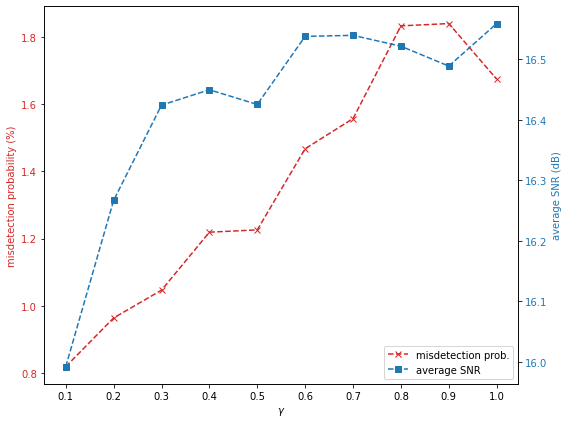

In [39]:
fig, ax1 = plt.subplots(figsize=(8,6))
color = 'tab:red'
ax1.set_xlabel('$\gamma$')
ax1.set_ylabel('misdetection probability (%)', color=color)
lns1=ax1.plot(gamma_arr, misdetection_rate_vs_gamma, color=color, linestyle='dashed', marker='x',label='misdetection prob.')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xticks(gamma_arr)

ax2 = ax1.twinx() 
color = 'tab:blue'
ax2.set_ylabel('average SNR (dB)', color=color)
lns2=ax2.plot(gamma_arr, pow_2_dB(dB_2_pow(snr_vs_gamma).mean(axis=-1)), color=color, linestyle='dashed', marker='s',label='average SNR')
ax2.tick_params(axis='y', labelcolor=color)

lns = lns1+lns2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc='lower right')

fig.tight_layout()
plt.show()

## Gain of using combined loss function (BF loss + IA loss)

In [40]:
n_probing_beam = 16 # defaul number of probing beams, I used 16 for O28 and 12 for I3
noise_power_dBm = -81 # noise power dBm
measurement_gain = 16.0 # spreading gain of probing measurements
gamma = 0.3 # trade-off between BF loss and misdetection loss
h_NMSE_dB = -np.inf # channel NMSE in dB, to generate noisy training data
IA_threshold = -5 # initial access SNR threshold in dB
random_UE_rotation = True
train_noise_power = 10**((noise_power_dBm-tx_power_dBm)/10)/measurement_gain # probing measurements SNR

beam_prediction_mode = 'GF'
num_feedback = None
feedback_mode = 'diagonal'
learned_probing = 'TxRx'
beam_synthesizer = 'MLP'
loss_fn = 'BF_IA_loss'

In [41]:
model_savefname_prefix = './Models/'

snr_vs_IA_th_per_gamma_dict = {}
misdetection_rate_vs_IA_th_per_gamma_dict = {}

SNR_th_arr = np.arange(-11,5,2)

for gamma in [0.3,1.0]:
    snr_vs_IA_th_per_gamma_dict[gamma] = []
    misdetection_rate_vs_IA_th_per_gamma_dict[gamma] = []

gamma = 0.3
for IA_threshold in SNR_th_arr:
    model = Joint_BF_Autoencoder(num_antenna_Tx = num_antenna_Tx, num_antenna_Rx = num_antenna_Rx, 
                                 num_probing_beam_Tx = n_probing_beam, num_probing_beam_Rx = n_probing_beam, 
                                 noise_power=train_noise_power, norm_factor=norm_factor,
                                 feedback=feedback_mode,num_feedback = num_feedback,
                                 learned_probing = learned_probing, beam_synthesizer = beam_synthesizer).cpu()
    model_setup_params = ("{}_BS_{}_{}_"+
                    "UE_rot_{}_"+
                    "{}_{}_probe_"+
                    "{}_FB_{}_"+
                    "{}_"+
                    "{}_gamma_{}_"+
                    "train_noise_{}_dBm_"+
                    "meas_gain_{}_"+
                    "IA_thresh_{}_"+
                    "h_NMSE_{}").format(parameters['scenario'], parameters['active_BS'][0],beam_prediction_mode,
                                        random_UE_rotation,
                                        n_probing_beam, learned_probing,
                                        feedback_mode, num_feedback,
                                        beam_synthesizer,
                                        loss_fn, gamma,
                                        noise_power_dBm,
                                        measurement_gain,
                                        IA_threshold,
                                        h_NMSE_dB)
    state_dict_load = torch.load(model_savefname_prefix+model_setup_params+'.pt')
    model.load_state_dict(state_dict_load)

    predicted_bf_gain, probing_codebook_bf_gain = eval_model(model,torch_x_test,h[test_idc],
                                                             noise_power=train_noise_power,prediction_mode=beam_prediction_mode,feedback_mode=feedback_mode)

    model_snr = tx_power_dBm + 10*np.log10(predicted_bf_gain) - noise_power_dBm
    snr_vs_IA_th_per_gamma_dict[gamma].append(model_snr)

    probing_beam_max_snr = tx_power_dBm + 10*np.log10(probing_codebook_bf_gain) - noise_power_dBm
    misdetection_rate_vs_IA_th_per_gamma_dict[gamma].append((probing_beam_max_snr<IA_threshold).mean()*100)

# use BF loss only, gamma = 1, loss function is independent of the IA SNR threshold
gamma = 1.0
IA_threshold = -5
model = Joint_BF_Autoencoder(num_antenna_Tx = num_antenna_Tx, num_antenna_Rx = num_antenna_Rx, 
                             num_probing_beam_Tx = n_probing_beam, num_probing_beam_Rx = n_probing_beam, 
                             noise_power=train_noise_power, norm_factor=norm_factor,
                             feedback=feedback_mode,num_feedback = num_feedback,
                             learned_probing = learned_probing, beam_synthesizer = beam_synthesizer).cpu()
model_setup_params = ("{}_BS_{}_{}_"+
                "UE_rot_{}_"+
                "{}_{}_probe_"+
                "{}_FB_{}_"+
                "{}_"+
                "{}_gamma_{}_"+
                "train_noise_{}_dBm_"+
                "meas_gain_{}_"+
                "IA_thresh_{}_"+
                "h_NMSE_{}").format(parameters['scenario'], parameters['active_BS'][0],beam_prediction_mode,
                                    random_UE_rotation,
                                    n_probing_beam, learned_probing,
                                    feedback_mode, num_feedback,
                                    beam_synthesizer,
                                    loss_fn, gamma,
                                    noise_power_dBm,
                                    measurement_gain,
                                    IA_threshold,
                                    h_NMSE_dB)
state_dict_load = torch.load(model_savefname_prefix+model_setup_params+'.pt')
model.load_state_dict(state_dict_load)

predicted_bf_gain, probing_codebook_bf_gain = eval_model(model,torch_x_test,h[test_idc],
                                                         noise_power=train_noise_power,prediction_mode=beam_prediction_mode,feedback_mode=feedback_mode)
model_snr = tx_power_dBm + 10*np.log10(predicted_bf_gain) - noise_power_dBm
probing_beam_max_snr = tx_power_dBm + 10*np.log10(probing_codebook_bf_gain) -noise_power_dBm
for IA_threshold in SNR_th_arr:
    snr_vs_IA_th_per_gamma_dict[gamma].append(model_snr)
    misdetection_rate_vs_IA_th_per_gamma_dict[gamma].append((probing_beam_max_snr<IA_threshold).mean()*100)
      
for gamma in [0.3,1.0]:
    snr_vs_IA_th_per_gamma_dict[gamma] = np.array(snr_vs_IA_th_per_gamma_dict[gamma])
    misdetection_rate_vs_IA_th_per_gamma_dict[gamma] = np.array(misdetection_rate_vs_IA_th_per_gamma_dict[gamma])  

e:\Anaconda\envs\p39\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


#### SNR and misdetection probablity vs. the SNR threshold for IA with and without incorporating the IA loss

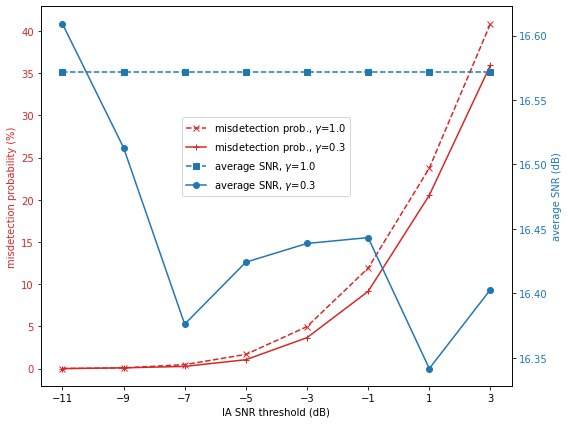

In [42]:
fig, ax1 = plt.subplots(figsize=(8,6))

color = 'tab:red'
ax1.set_xlabel('IA SNR threshold (dB)')
ax1.set_ylabel('misdetection probability (%)', color=color)
lns1=ax1.plot(SNR_th_arr, misdetection_rate_vs_IA_th_per_gamma_dict[1.0], color=color, linestyle='dashed', marker='x',label='misdetection prob., $\gamma$={}'.format(1.0))
lns2=ax1.plot(SNR_th_arr, misdetection_rate_vs_IA_th_per_gamma_dict[0.3], color=color, marker='+',label='misdetection prob., $\gamma$={}'.format(0.3))
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xticks(SNR_th_arr)

ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('average SNR (dB)', color=color) 
lns3=ax2.plot(SNR_th_arr, pow_2_dB(dB_2_pow(snr_vs_IA_th_per_gamma_dict[1.0]).mean(axis=1)), color=color, linestyle='dashed', marker='s',label='average SNR, $\gamma$={}'.format(1.0))
lns4=ax2.plot(SNR_th_arr, pow_2_dB(dB_2_pow(snr_vs_IA_th_per_gamma_dict[0.3]).mean(axis=1)), color=color, marker='o',label='average SNR, $\gamma$={}'.format(0.3))
ax2.tick_params(axis='y', labelcolor=color)

lns = lns1+lns2+lns3+lns4
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=(0.3,0.5))

fig.tight_layout()
plt.show()

#### SNR and misdetection probablity vs. the number of probing beams with and without incorporating the IA loss

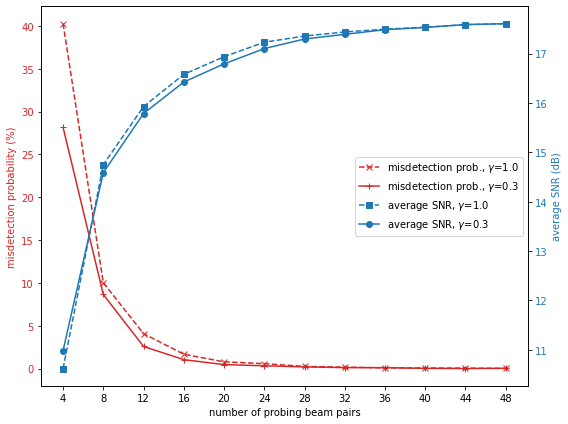

In [43]:
fig, ax1 = plt.subplots(figsize=(8,6))

color = 'tab:red'
ax1.set_xlabel('number of probing beam pairs')
ax1.set_ylabel('misdetection probability (%)', color=color)
lns1=ax1.plot(n_pb_arr, misdetection_rate_vs_npb_dict['GF_MLP_TxRx_diagonal_None_1.0'], color=color, linestyle='dashed', marker='x',label='misdetection prob., $\gamma$={}'.format(1.0))
lns2=ax1.plot(n_pb_arr, misdetection_rate_vs_npb_dict['GF_MLP_TxRx_diagonal_None_0.3'], color=color, marker='+',label='misdetection prob., $\gamma$={}'.format(0.3))
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xticks(n_pb_arr)

ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('average SNR (dB)', color=color)  
lns3=ax2.plot(n_pb_arr, pow_2_dB(dB_2_pow(snr_vs_npb_dict['GF_MLP_TxRx_diagonal_None_1.0']).mean(axis=-1)), color=color, linestyle='dashed', marker='s',label='average SNR, $\gamma$={}'.format(1.0))
lns4=ax2.plot(n_pb_arr, pow_2_dB(dB_2_pow(snr_vs_npb_dict['GF_MLP_TxRx_diagonal_None_0.3']).mean(axis=-1)), color=color, marker='o',label='average SNR, $\gamma$={}'.format(0.3))
ax2.tick_params(axis='y', labelcolor=color)

lns = lns1+lns2+lns3+lns4
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc='center right')

fig.tight_layout()  
plt.show()

## Avg. SNR vs Measurement Noise

In [44]:
n_probing_beam = 32 # defaul number of probing beams
noise_power_dBm = -81 # noise power dBm
measurement_gain = 16.0 # spreading gain of probing measurements
gamma = 0.3 # trade-off between BF loss and misdetection loss
h_NMSE_dB = -np.inf # channel NMSE in dB, to generate noisy training data
IA_threshold = -5 # initial access SNR threshold in dB
random_UE_rotation = True
train_noise_power = 10**((noise_power_dBm-tx_power_dBm)/10)/measurement_gain # probing measurements SNR

beam_prediction_mode = 'GF'
num_feedback = None
feedback_mode = 'diagonal'
learned_probing = 'TxRx'
beam_synthesizer = 'MLP'
loss_fn = 'BF_IA_loss'

In [45]:
spreading_gain_arr = np.arange(-36,13,6)+10*np.log10(16)

model_savefname_prefix = './Models/'

snr_vs_spreading_gain_dict = {}
misdetection_rate_vs_spreading_gain_dict = {}

for beam_prediction_mode in ['GF','CB']:
    snr_vs_spreading_gain_dict[beam_prediction_mode] = []
    misdetection_rate_vs_spreading_gain_dict[beam_prediction_mode] = []
    for spreading_gain in spreading_gain_arr:
        train_noise_power = 10**((noise_power_dBm-tx_power_dBm-spreading_gain)/10)
        if beam_prediction_mode == 'GF':
            model = Joint_BF_Autoencoder(num_antenna_Tx = num_antenna_Tx, num_antenna_Rx = num_antenna_Rx, 
                                         num_probing_beam_Tx = n_probing_beam, num_probing_beam_Rx = n_probing_beam, 
                                         noise_power=train_noise_power, norm_factor=norm_factor,
                                         feedback=feedback_mode,num_feedback = num_feedback,
                                         learned_probing = learned_probing, beam_synthesizer = beam_synthesizer).cpu()
            loss_fn = 'BF_IA_loss'
            gamma = 0.3
        else:
            model = Joint_BF_Classifier(num_antenna_Tx = num_antenna_Tx, num_antenna_Rx = num_antenna_Rx,
                                        num_probing_beam_Tx = n_probing_beam, num_probing_beam_Rx = n_probing_beam, 
                                        num_Tx_beams = int(16*16), num_Rx_beams = int(8*8),
                                        noise_power=train_noise_power, norm_factor=norm_factor).cpu()   
            loss_fn = 'CE'
            gamma = None
        model_setup_params = ("{}_BS_{}_{}_"+
                        "UE_rot_{}_"+
                        "{}_{}_probe_"+
                        "{}_FB_{}_"+
                        "{}_"+
                        "{}_gamma_{}_"+
                        "train_noise_{}_dBm_"+
                        "meas_gain_{}_"+
                        "IA_thresh_{}_"+
                        "h_NMSE_{}").format(parameters['scenario'], parameters['active_BS'][0],beam_prediction_mode,
                                            random_UE_rotation,
                                            n_probing_beam, learned_probing,
                                            feedback_mode, num_feedback,
                                            beam_synthesizer,
                                            loss_fn, gamma,
                                            noise_power_dBm,
                                            f'{10**(spreading_gain/10):.3f}',
                                            IA_threshold,
                                            h_NMSE_dB)
        state_dict_load = torch.load(model_savefname_prefix+model_setup_params+'.pt')
        model.load_state_dict(state_dict_load)

        predicted_bf_gain, probing_codebook_bf_gain = eval_model(model,torch_x_test,h[test_idc],
                                                                 noise_power=train_noise_power,prediction_mode=beam_prediction_mode,feedback_mode=feedback_mode)

        model_snr = tx_power_dBm + 10*np.log10(predicted_bf_gain) - noise_power_dBm
        snr_vs_spreading_gain_dict[beam_prediction_mode].append(model_snr)

        probing_beam_max_snr = tx_power_dBm + 10*np.log10(probing_codebook_bf_gain) - noise_power_dBm
        misdetection_rate_vs_spreading_gain_dict[beam_prediction_mode].append((probing_beam_max_snr<IA_threshold).mean()*100)

    snr_vs_spreading_gain_dict[beam_prediction_mode] = np.array(snr_vs_spreading_gain_dict[beam_prediction_mode])
    misdetection_rate_vs_spreading_gain_dict[beam_prediction_mode] = np.array(misdetection_rate_vs_spreading_gain_dict[beam_prediction_mode])      

e:\Anaconda\envs\p39\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [46]:
DFT_codebook_TX = UPA_DFT_codebook(n_azimuth=8*2,n_elevation=8*2,n_antenna_azimuth=8,n_antenna_elevation=8,spacing=0.5).T
DFT_codebook_RX = UPA_DFT_codebook(n_azimuth=4*2,n_elevation=4*2,n_antenna_azimuth=4,n_antenna_elevation=4,spacing=0.5).T
normalized_exhaustive_snr_vs_spreading_gain = []
for spreading_gain in spreading_gain_arr:
    train_noise_power = 10**((noise_power_dBm-tx_power_dBm-spreading_gain)/10)
    """    
    compute exhaustive beam search snr
    """
    dft_rx_bf_signal = h[test_idc] @ DFT_codebook_TX
    rx_noise_real = np.random.normal(loc=0,scale=1,size=dft_rx_bf_signal.shape)*np.sqrt(train_noise_power/2)
    rx_noise_imag = np.random.normal(loc=0,scale=1,size=dft_rx_bf_signal.shape)*np.sqrt(train_noise_power/2)
    dft_rx_bf_signal_w_noise = dft_rx_bf_signal + rx_noise_real + 1j*rx_noise_imag
    dft_bf_signal_w_noise = DFT_codebook_RX.conj().T @ dft_rx_bf_signal_w_noise
    dft_bf_signal_wo_noise = DFT_codebook_RX.conj().T @ dft_rx_bf_signal
    dft_bf_gain_w_noise =  np.power(np.absolute(dft_bf_signal_w_noise),2)
    dft_bf_gain_wo_noise =  np.power(np.absolute(dft_bf_signal_wo_noise),2)
    optimal_beam_pair_exhaustive = dft_bf_gain_w_noise.reshape(dft_bf_gain_w_noise.shape[0],-1).argmax(axis=-1)
    exhaustive_DFT_gain = dft_bf_gain_wo_noise.reshape(dft_bf_gain_wo_noise.shape[0],-1)[np.arange(dft_bf_gain_wo_noise.shape[0]),optimal_beam_pair_exhaustive]
    exhaustive_DFT_snr = tx_power_dBm + 10*np.log10(exhaustive_DFT_gain.mean()) - noise_power_dBm
    normalized_exhaustive_snr_vs_spreading_gain.append(exhaustive_DFT_snr)
# np.save('./Data/normalized_exhaustive_snr_vs_spreading_gain_{}_BS_{}_new.npy'.format(scenario,BS_arr[0]),normalized_exhaustive_snr_vs_noise_figure)
# normalized_exhaustive_snr_vs_spreading_gain = np.load('./Data/normalized_exhaustive_snr_vs_spreading_gain_{}_BS_{}.npy'.format(scenario,BS_arr[0]),allow_pickle=True)

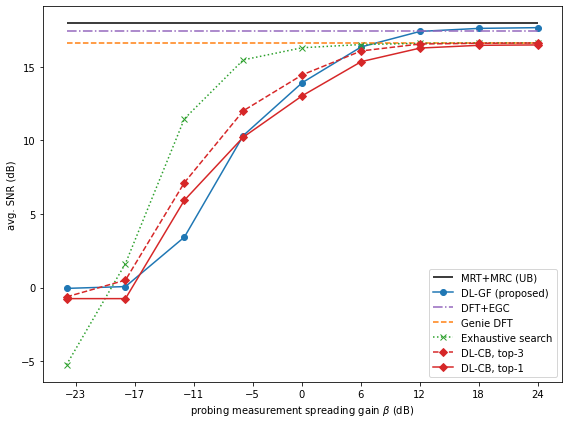

In [47]:
fig = plt.figure(figsize=(8,6))
plt.hlines(y=pow_2_dB(dB_2_pow(snr_baselines['MRT_MRC']).mean(axis=-1)),xmin=min(spreading_gain_arr),xmax=max(spreading_gain_arr),color='black',linestyles='solid',label='MRT+MRC (UB)')
plt.plot(spreading_gain_arr,pow_2_dB(dB_2_pow(snr_vs_spreading_gain_dict['GF']).mean(axis=-1)),color='tab:blue',marker='o',label='DL-GF (proposed)')
plt.hlines(y=pow_2_dB(dB_2_pow(snr_baselines['DFT_EGC']).mean()),xmin=min(spreading_gain_arr),xmax=max(spreading_gain_arr),color='tab:purple',linestyles='dashdot',label='DFT+EGC')
plt.hlines(y=pow_2_dB(dB_2_pow(snr_baselines['genie_DFT']).mean()),xmin=min(spreading_gain_arr),xmax=max(spreading_gain_arr),color='tab:orange',linestyles='dashed',label='Genie DFT')
plt.plot(spreading_gain_arr,normalized_exhaustive_snr_vs_spreading_gain,marker='x',color='tab:green',linestyle='dotted',label='Exhaustive search')
plt.plot(spreading_gain_arr,pow_2_dB(dB_2_pow(snr_vs_spreading_gain_dict['CB'][:,1,:]).mean(axis=-1)),color='tab:red',linestyle='dashed',marker='D',label='DL-CB, top-3')
plt.plot(spreading_gain_arr,pow_2_dB(dB_2_pow(snr_vs_spreading_gain_dict['CB'][:,0,:]).mean(axis=-1)),color='tab:red',linestyle='solid',marker='D',label='DL-CB, top-1')
plt.legend(loc='lower right')
plt.xticks(spreading_gain_arr.astype(int))
plt.xlabel(r'probing measurement spreading gain $\beta$ (dB)')
plt.ylabel('avg. SNR (dB)')
plt.tight_layout()
plt.show()

## Robustness to noisy training data (higher channel estimation NMSE)

In [48]:
n_probing_beam = 32 # defaul number of probing beams
noise_power_dBm = -81 # noise power dBm
measurement_gain = 16.0 # spreading gain of probing measurements
gamma = 0.3 # trade-off between BF loss and misdetection loss
h_NMSE_dB = -np.inf # channel NMSE in dB, to generate noisy training data
IA_threshold = -5 # initial access SNR threshold in dB
random_UE_rotation = True
train_noise_power = 10**((noise_power_dBm-tx_power_dBm)/10)/measurement_gain # probing measurements SNR

beam_prediction_mode = 'GF'
num_feedback = None
feedback_mode = 'diagonal'
learned_probing = 'TxRx'
beam_synthesizer = 'MLP'

In [49]:
h_NMSE_arr = list(np.arange(-11,5,2))
h_NMSE_arr.append(-np.inf) 

model_savefname_prefix = './Models/'

snr_vs_h_NMSE_dict = {}
misdetection_rate_vs_h_NMSE_dict = {}

for beam_prediction_mode in ['GF','CB']:
    snr_vs_h_NMSE_dict[beam_prediction_mode] = []
    misdetection_rate_vs_h_NMSE_dict[beam_prediction_mode] = []
    for h_NMSE_dB in h_NMSE_arr:
        if beam_prediction_mode == 'GF':
            model = Joint_BF_Autoencoder(num_antenna_Tx = num_antenna_Tx, num_antenna_Rx = num_antenna_Rx, 
                                         num_probing_beam_Tx = n_probing_beam, num_probing_beam_Rx = n_probing_beam, 
                                         noise_power=train_noise_power, norm_factor=norm_factor,
                                         feedback=feedback_mode,num_feedback = num_feedback,
                                         learned_probing = learned_probing, beam_synthesizer = beam_synthesizer).cpu()
            loss_fn = 'BF_IA_loss'
            gamma = 0.3
        else:
            model = Joint_BF_Classifier(num_antenna_Tx = num_antenna_Tx, num_antenna_Rx = num_antenna_Rx,
                                        num_probing_beam_Tx = n_probing_beam, num_probing_beam_Rx = n_probing_beam, 
                                        num_Tx_beams = int(16*16), num_Rx_beams = int(8*8),
                                        noise_power=train_noise_power, norm_factor=norm_factor).cpu()   
            loss_fn = 'CE'
            gamma = None
        model_setup_params = ("{}_BS_{}_{}_"+
                        "UE_rot_{}_"+
                        "{}_{}_probe_"+
                        "{}_FB_{}_"+
                        "{}_"+
                        "{}_gamma_{}_"+
                        "train_noise_{}_dBm_"+
                        "meas_gain_{}_"+
                        "IA_thresh_{}_"+
                        "h_NMSE_{}").format(parameters['scenario'], parameters['active_BS'][0], beam_prediction_mode,
                                            random_UE_rotation,
                                            n_probing_beam, learned_probing,
                                            feedback_mode, num_feedback,
                                            beam_synthesizer,
                                            loss_fn, gamma,
                                            noise_power_dBm,
                                            measurement_gain,
                                            IA_threshold,
                                            h_NMSE_dB)
        state_dict_load = torch.load(model_savefname_prefix+model_setup_params+'.pt')
        model.load_state_dict(state_dict_load)

        predicted_bf_gain, probing_codebook_bf_gain = eval_model(model,torch_x_test,h[test_idc],
                                                                 noise_power=train_noise_power,prediction_mode=beam_prediction_mode,feedback_mode=feedback_mode)

        model_snr = tx_power_dBm + 10*np.log10(predicted_bf_gain) - noise_power_dBm
        snr_vs_h_NMSE_dict[beam_prediction_mode].append(model_snr)

        probing_beam_max_snr = tx_power_dBm + 10*np.log10(probing_codebook_bf_gain) - noise_power_dBm
        misdetection_rate_vs_h_NMSE_dict[beam_prediction_mode].append((probing_beam_max_snr<IA_threshold).mean()*100)

    snr_vs_h_NMSE_dict[beam_prediction_mode] = np.array(snr_vs_h_NMSE_dict[beam_prediction_mode])
    misdetection_rate_vs_h_NMSE_dict[beam_prediction_mode] = np.array(misdetection_rate_vs_h_NMSE_dict[beam_prediction_mode])      

e:\Anaconda\envs\p39\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


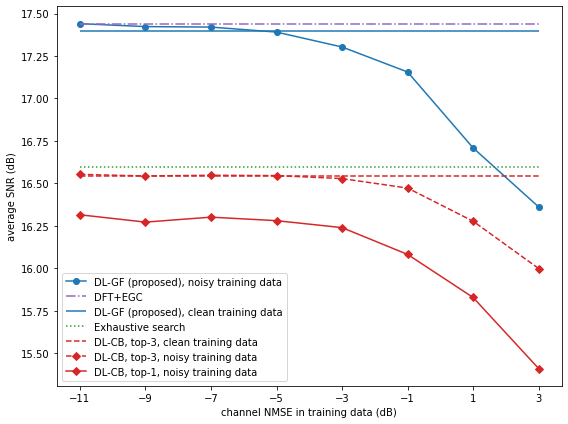

In [50]:
plt.figure(figsize=(8,6))
plt.plot(h_NMSE_arr[:-1], pow_2_dB(dB_2_pow(snr_vs_h_NMSE_dict['GF'][:-1,:]).mean(axis=-1)), color='tab:blue', marker='o',label='DL-GF (proposed), noisy training data')
plt.hlines(y=pow_2_dB(dB_2_pow(snr_baselines['DFT_EGC']).mean()),xmin=min(h_NMSE_arr[:-1]),xmax=max(h_NMSE_arr[:-1]),color='tab:purple',linestyles='dashdot',label='DFT+EGC')
plt.hlines(y=pow_2_dB(dB_2_pow(snr_vs_h_NMSE_dict['GF'][-1,:]).mean()),xmin=min(h_NMSE_arr[:-1]),xmax=max(h_NMSE_arr[:-1]),color='tab:blue',linestyles='solid',label='DL-GF (proposed), clean training data')     
plt.hlines(y=pow_2_dB(dB_2_pow(snr_baselines['exhaustive']).mean()),xmin=min(h_NMSE_arr[:-1]),xmax=max(h_NMSE_arr[:-1]),color='tab:green',linestyles='dotted',label='Exhaustive search')
plt.hlines(y=pow_2_dB(dB_2_pow(snr_vs_h_NMSE_dict['CB'][-1,1,:]).mean()),xmin=min(h_NMSE_arr[:-1]),xmax=max(h_NMSE_arr[:-1]),color='tab:red',linestyles='dashed',label='DL-CB, top-3, clean training data')     
plt.plot(h_NMSE_arr[:-1], pow_2_dB(dB_2_pow(snr_vs_h_NMSE_dict['CB'][:-1,1,:]).mean(axis=-1)), color='tab:red', marker='D',linestyle='dashed',label='DL-CB, top-3, noisy training data')
plt.plot(h_NMSE_arr[:-1], pow_2_dB(dB_2_pow(snr_vs_h_NMSE_dict['CB'][:-1,0,:]).mean(axis=-1)), color='tab:red', marker='D',label='DL-CB, top-1, noisy training data')
plt.xlabel('channel NMSE in training data (dB)')
plt.ylabel('average SNR (dB)')
plt.legend()
plt.xticks(h_NMSE_arr[:-1])
plt.tight_layout()
plt.show()


## SNR vs. beam alignment speed trade-off (capacity region)

In [51]:
n_probing_beam = 16 # defaul number of probing beams
noise_power_dBm = -81 # noise power dBm
measurement_gain = 16.0 # spreading gain of probing measurements
gamma = 0.3 # trade-off between BF loss and misdetection loss
h_NMSE_dB = -np.inf # channel NMSE in dB, to generate noisy training data
IA_threshold = -5 # initial access SNR threshold in dB
random_UE_rotation = True
train_noise_power = 10**((noise_power_dBm-tx_power_dBm)/10)/measurement_gain # probing measurements SNR

beam_prediction_mode = 'GF'
num_feedback = None
feedback_mode = 'diagonal'
learned_probing = 'TxRx'
beam_synthesizer = 'MLP'

#### Load models with a wide range of probing/sensing codebook sizes

In [52]:
n_pb_arr = np.array([2,4,8,12,16,20,24,28,32,36,40,44,48,128,256])

snr_vs_ba_speed_dict = {}

model_savefname_prefix = './Models/'

for beam_prediction_mode in ['GF','CB']:
    snr_vs_ba_speed_dict[beam_prediction_mode] = []                
    for n_probing_beam in n_pb_arr:
        if beam_prediction_mode == 'GF':
            model = Joint_BF_Autoencoder(num_antenna_Tx = num_antenna_Tx, num_antenna_Rx = num_antenna_Rx, 
                                         num_probing_beam_Tx = n_probing_beam, num_probing_beam_Rx = n_probing_beam, 
                                         noise_power=train_noise_power, norm_factor=norm_factor,
                                         feedback=feedback_mode,num_feedback = num_feedback,
                                         learned_probing = learned_probing, beam_synthesizer = beam_synthesizer).cpu()
            loss_fn = 'BF_IA_loss'
            gamma = 0.3
        else:
            model = Joint_BF_Classifier(num_antenna_Tx = num_antenna_Tx, num_antenna_Rx = num_antenna_Rx,
                                        num_probing_beam_Tx = n_probing_beam, num_probing_beam_Rx = n_probing_beam, 
                                        num_Tx_beams = int(16*16), num_Rx_beams = int(8*8),
                                        noise_power=train_noise_power, norm_factor=norm_factor).cpu()   
            loss_fn = 'CE'
            gamma = None
        model_setup_params = ("{}_BS_{}_{}_"+
                        "UE_rot_{}_"+
                        "{}_{}_probe_"+
                        "{}_FB_{}_"+
                        "{}_"+
                        "{}_gamma_{}_"+
                        "train_noise_{}_dBm_"+
                        "meas_gain_{}_"+
                        "IA_thresh_{}_"+
                        "h_NMSE_{}").format(parameters['scenario'], parameters['active_BS'][0], beam_prediction_mode,
                                            random_UE_rotation,
                                            n_probing_beam, learned_probing,
                                            feedback_mode, num_feedback,
                                            beam_synthesizer,
                                            loss_fn, gamma,
                                            noise_power_dBm,
                                            measurement_gain,
                                            IA_threshold,
                                            h_NMSE_dB)
        try:
            state_dict_load = torch.load(model_savefname_prefix+model_setup_params+'.pt')
            model.load_state_dict(state_dict_load)
        except FileNotFoundError:
            print(n_probing_beam)
        
        predicted_bf_gain, probing_codebook_bf_gain = eval_model(model,torch_x_test,h[test_idc],
                                                                 noise_power=train_noise_power,prediction_mode=beam_prediction_mode,feedback_mode=feedback_mode)
        
        model_snr = tx_power_dBm + 10*np.log10(predicted_bf_gain) - noise_power_dBm
        snr_vs_ba_speed_dict[beam_prediction_mode].append(model_snr)

    snr_vs_ba_speed_dict[beam_prediction_mode] = np.array(snr_vs_ba_speed_dict[beam_prediction_mode])

e:\Anaconda\envs\p39\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


#### compute the SNR and latency for exhaustive search with different (sub-sampled) DFT codebook sizes

In [53]:
eval_noise_power = 10**((noise_power_dBm-tx_power_dBm)/10)/measurement_gain

nb_dft_tx_arr = np.array([2,4,4,5,7,7,8,9,11,13,16])
nb_dft_rx_arr = np.array([2,1,2,2,2,3,4,5,6,7,8])
snr_vs_exhaustive_latency = {'snr':[],'latency':nb_dft_tx_arr**2*nb_dft_rx_arr**2}

for n_dft_tx, n_dft_rx in zip(nb_dft_tx_arr,nb_dft_rx_arr):
    DFT_codebook_TX = UPA_DFT_codebook(n_azimuth=n_dft_tx,n_elevation=n_dft_tx,n_antenna_azimuth=8,n_antenna_elevation=8,spacing=0.5).T
    DFT_codebook_RX = UPA_DFT_codebook(n_azimuth=n_dft_rx,n_elevation=n_dft_rx,n_antenna_azimuth=4,n_antenna_elevation=4,spacing=0.5).T 
    """    
    compute exhaustive beam search snr
    """
    dft_rx_bf_signal = h[test_idc] @ DFT_codebook_TX
    dft_bf_signal_wo_noise = DFT_codebook_RX.conj().T @ dft_rx_bf_signal
    dft_bf_gain_wo_noise =  np.power(np.absolute(dft_bf_signal_wo_noise),2)

    rx_noise_real = np.random.normal(loc=0,scale=1,size=dft_rx_bf_signal.shape)*np.sqrt(eval_noise_power/2)
    rx_noise_imag = np.random.normal(loc=0,scale=1,size=dft_rx_bf_signal.shape)*np.sqrt(eval_noise_power/2)
    dft_rx_bf_signal_w_noise = dft_rx_bf_signal + rx_noise_real + 1j*rx_noise_imag
    dft_bf_signal_w_noise = DFT_codebook_RX.conj().T @ dft_rx_bf_signal_w_noise
    dft_bf_gain_w_noise =  np.power(np.absolute(dft_bf_signal_w_noise),2)
    optimal_beam_pair_exhaustive = dft_bf_gain_w_noise.reshape(dft_bf_gain_w_noise.shape[0],-1).argmax(axis=-1)
    bf_gain_exhaustive = dft_bf_gain_wo_noise.reshape(dft_bf_gain_wo_noise.shape[0],-1)[np.arange(dft_bf_gain_wo_noise.shape[0]),optimal_beam_pair_exhaustive]
    snr_exhaustive = tx_power_dBm + 10*np.log10(bf_gain_exhaustive.mean()) - noise_power_dBm
    snr_vs_exhaustive_latency['snr'].append(snr_exhaustive)
    
snr_vs_exhaustive_latency['snr'] = np.array(snr_vs_exhaustive_latency['snr'])    
# np.save('./Data/snr_vs_exhaustive_latency_dict_{}_BS_{}.npy'.format(scenario,BS_arr[0]),snr_vs_exhaustive_latency,allow_pickle=True) 
# snr_vs_exhaustive_latency = np.load('./Data/snr_vs_exhaustive_latency_dict_{}_BS_{}.npy'.format(scenario,BS_arr[0]),allow_pickle=True).item()

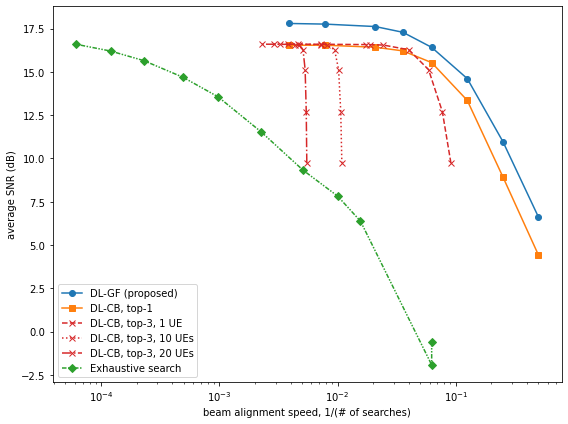

In [54]:
gf_sel = [0,1,2,4,7,12,13,14]
cb_1_ue_sel = [0,1,2,4,8,11,12,13,14]
cb_10_ue_sel = [0,1,2,4,8,12,13,14]
cb_20_ue_sel = [0,1,2,4,8,12,13,14]

ba_speed_1ue,ba_speed_10ue,ba_speed_20ue = [],[],[]
topk = 3
snr_per_latency_cb_dict = {1:{},10:{},20:{}}
for n_probing_beam in n_pb_arr:
    ba_speed_1ue.append(n_probing_beam + 1*topk**2)
    ba_speed_10ue.append(n_probing_beam + 10*topk**2)
    ba_speed_20ue.append(n_probing_beam + 20*topk**2)
    
ba_speed_1ue = np.array(ba_speed_1ue)
ba_speed_10ue = np.array(ba_speed_10ue)
ba_speed_20ue = np.array(ba_speed_20ue)

snr_vs_exhaustive_search_x = 1/np.array(snr_vs_exhaustive_latency['latency'])
snr_vs_exhaustive_search_y = np.array(snr_vs_exhaustive_latency['snr'])

plt.figure(figsize=(8,6))
plt.plot(1/n_pb_arr[gf_sel], pow_2_dB(dB_2_pow(snr_vs_ba_speed_dict['GF'][gf_sel,:]).mean(axis=-1)), color='tab:blue', marker='o', label='DL-GF (proposed)')
plt.plot(1/n_pb_arr[gf_sel], pow_2_dB(dB_2_pow(snr_vs_ba_speed_dict['CB'][gf_sel,0,:]).mean(axis=-1)), color='tab:orange', marker='s', linestyle='solid', label='DL-CB, top-1')
plt.plot(1/ba_speed_1ue[cb_1_ue_sel], pow_2_dB(dB_2_pow(snr_vs_ba_speed_dict['CB'][cb_1_ue_sel,1,:]).mean(axis=-1)), color='tab:red', marker='x', linestyle='dashed', label='DL-CB, top-3, 1 UE')
plt.plot(1/ba_speed_10ue[cb_10_ue_sel], pow_2_dB(dB_2_pow(snr_vs_ba_speed_dict['CB'][cb_10_ue_sel,1,:]).mean(axis=-1)), color='tab:red', marker='x', linestyle='dotted', label='DL-CB, top-3, 10 UEs')
plt.plot(1/ba_speed_20ue[cb_20_ue_sel], pow_2_dB(dB_2_pow(snr_vs_ba_speed_dict['CB'][cb_20_ue_sel,1,:]).mean(axis=-1)), color='tab:red', marker='x', linestyle='dashdot', label='DL-CB, top-3, 20 UEs')
plt.plot(snr_vs_exhaustive_search_x, snr_vs_exhaustive_search_y, color='tab:green', marker='D', linestyle=(0, (3, 1, 1, 1, 1, 1)), label='Exhaustive search')
plt.xlabel('beam alignment speed, 1/(# of searches)')
plt.ylabel('average SNR (dB)')
plt.legend(loc='lower left')
plt.xscale('log')
plt.tight_layout()  
plt.show()

## Impact of random UE orientations

In [56]:
scenario = 'O1_28' # DeepMIMO Ray-tracing scenario
activated_BS = 3 # Index of activated BS in the scenario
random_UE_rotation = False # True: UE rotation is random, False: UE rotation is fixed
array_type = 'UPA' # BS and UE array type, ULA or UPA

# Set the BS transmit power in dBm
if scenario == 'O1_28':
    tx_power_dBm = 20
elif scenario == 'O1_28B':
    tx_power_dBm = 35    
elif scenario == 'I3_60':
    if activated_BS==1:
        tx_power_dBm = 15
    elif activated_BS==2:
        tx_power_dBm = 20
    else:
        raise Exception("Unsupported BS activation!") 
else:
    raise Exception("Unsupported Ray-Tracing Scenario!")

# UE grid depending on the scenario
if scenario == 'O1_28':
    BS_arr = np.array([3])
    ue_row_first = 800
    ue_row_last = 1200
elif scenario == 'O1_28B':
    BS_arr = np.array([3])
    ue_row_first = 1
    ue_row_last = 2751    
elif scenario == 'I3_60':
    BS_arr = np.array([activated_BS])
    ue_row_first = 1
    ue_row_last = 1159
else:
    raise Exception("Unsupported Ray-Tracing Scenario!")

# Generate the DeepMIMO dataset
parameters = DeepMIMO.default_params()
parameters['dataset_folder'] = 'D:/Github Repositories/DeepMIMO-codes/DeepMIMOv2/Raytracing_scenarios' # replace with your DeepMIMO dataset folder

parameters['scenario'] = scenario
parameters['num_paths'] = 25
parameters['active_BS'] = BS_arr
parameters['user_row_first'] = ue_row_first
parameters['user_row_last'] = ue_row_last
parameters['row_subsampling'] = 1
parameters['user_subsampling'] = 1

parameters['bs_antenna']['shape'] = np.array([1, 8, 8])
parameters['bs_antenna']['spacing'] = 0.5
parameters['bs_antenna']['radiation_pattern'] = 'isotropic'

parameters['ue_antenna']['shape'] = np.array([1, 4, 4])
parameters['ue_antenna']['spacing'] = 0.5
if random_UE_rotation:
    parameters['ue_antenna']['rotation'] = np.array([[-180,180],[-90,90],[-90,90]])
parameters['ue_antenna']['radiation_pattern'] = 'isotropic'

parameters['enable_BS2BS'] = 0

parameters['OFDM_channels'] = 1 # Frequency (OFDM) or time domain channels
parameters['OFDM']['subcarriers'] = 512
parameters['OFDM']['subcarriers_limit'] = 1
parameters['OFDM']['subcarriers_sampling'] = 1
parameters['OFDM']['bandwidth'] = 0.1
parameters['OFDM']['RX_filter'] = 0

dataset_no_rotation = DeepMIMO.generate_data(parameters)
h_no_rotation = dataset_no_rotation[0]['user']['channel'].squeeze()

eigen_bf_gain_path = './Data/eigen_bf_gain_{}_BS_{}_BS_array_{}x{}x{}_UE_array_{}x{}x{}.npy'.format(parameters['scenario'],parameters['active_BS'][0],
                                                                                        parameters['bs_antenna'][0]['shape'][0],parameters['bs_antenna'][0]['shape'][1],parameters['bs_antenna'][0]['shape'][2],
                                                                                        parameters['ue_antenna']['shape'][0],parameters['ue_antenna']['shape'][1],parameters['ue_antenna']['shape'][2])
if exists(eigen_bf_gain_path):
    eigen_bf_gain = np.load(eigen_bf_gain_path,allow_pickle=True)
else:
    eigen_bf_gain = np.linalg.eigvalsh(np.transpose(h.conj(),axes=(0,2,1)) @ h)[:,-1] # compute the max eigenvalue of the channel covariance matrix, this is the uppero bound of the BF gain
    np.save(eigen_bf_gain_path,eigen_bf_gain,allow_pickle=True)
eigen_snr = tx_power_dBm+10*np.log10(eigen_bf_gain)-noise_power_dBm # SNR with eigen beamforming
reachable_ue = eigen_snr>IA_threshold   # remove UEs that are impossible to complete IA with eigen beamforming
print('Removed {} out of {} UEs that are below the IA SNR threshold ({} dB).'.format((~reachable_ue).sum(),h_no_rotation.shape[0],IA_threshold))    
h_no_rotation = h_no_rotation[reachable_ue]

norm_factor_no_rotation = np.max(abs(h_no_rotation))
h_no_rotation_scaled = (h_no_rotation.T/norm_factor_no_rotation).T

x_test_no_rotation = h_no_rotation_scaled[test_idc]
torch_x_test_no_rotation = torch.from_numpy(x_test_no_rotation)


Basestation 3

UE-BS Channels


Generating channels: 100%|██████████| 72581/72581 [00:15<00:00, 4563.23it/s]


Removed 0 out of 72581 UEs that are below the IA SNR threshold (-5 dB).


In [57]:
noise_power_dBm = -81
measurement_gain = 16.0
h_NMSE_dB = -np.inf
train_noise_power = 10**((noise_power_dBm-tx_power_dBm)/10)/measurement_gain
IA_threshold = -5
beam_prediction_mode = 'GF'
beam_synthesizer = 'MLP'
feedback_mode = 'diagonal'
learned_probing = 'TxRx'
num_feedback = None
gamma = 0.3
random_UE_rotation = False
loss_fn = 'BF_IA_loss'

n_pb_arr = np.arange(4,49,4)

snr_vs_npb_no_rotation = []
misdetection_rate_vs_npb_no_rotation = []

model_savefname_prefix = './Models/'

for n_probing_beam in n_pb_arr:
    model = Joint_BF_Autoencoder(num_antenna_Tx = num_antenna_Tx, num_antenna_Rx = num_antenna_Rx, 
                                 num_probing_beam_Tx = n_probing_beam, num_probing_beam_Rx = n_probing_beam, 
                                 noise_power=train_noise_power, norm_factor=norm_factor,
                                 feedback=feedback_mode,num_feedback = num_feedback,
                                 learned_probing = learned_probing, beam_synthesizer = beam_synthesizer).cpu()
    model_setup_params = ("{}_BS_{}_{}_"+
                    "UE_rot_{}_"+
                    "{}_{}_probe_"+
                    "{}_FB_{}_"+
                    "{}_"+
                    "{}_gamma_{}_"+
                    "train_noise_{}_dBm_"+
                    "meas_gain_{}_"+
                    "IA_thresh_{}_"+
                    "h_NMSE_{}").format(parameters['scenario'], parameters['active_BS'][0], beam_prediction_mode,
                                        random_UE_rotation,
                                        n_probing_beam, learned_probing,
                                        feedback_mode, num_feedback,
                                        beam_synthesizer,
                                        loss_fn, gamma,
                                        noise_power_dBm,
                                        measurement_gain,
                                        IA_threshold,
                                        h_NMSE_dB)
    try:
        state_dict_load = torch.load(model_savefname_prefix+model_setup_params+'.pt')
        model.load_state_dict(state_dict_load)
    except FileNotFoundError:
        print(n_probing_beam)


    predicted_bf_gain, probing_codebook_bf_gain = eval_model(model,torch_x_test_no_rotation,h_no_rotation[test_idc],
                                                             noise_power=train_noise_power,prediction_mode=beam_prediction_mode,feedback_mode=feedback_mode)

    model_snr = tx_power_dBm + 10*np.log10(predicted_bf_gain) - noise_power_dBm
    snr_vs_npb_no_rotation.append(model_snr)
    
    probing_beam_max_snr = tx_power_dBm + 10*np.log10(probing_codebook_bf_gain) - noise_power_dBm
    misdetection_rate_vs_npb_no_rotation.append((probing_beam_max_snr<IA_threshold).mean()*100)    

snr_vs_npb_no_rotation = np.array(snr_vs_npb_no_rotation)
misdetection_rate_vs_npb_no_rotation = np.array(misdetection_rate_vs_npb_no_rotation)

e:\Anaconda\envs\p39\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


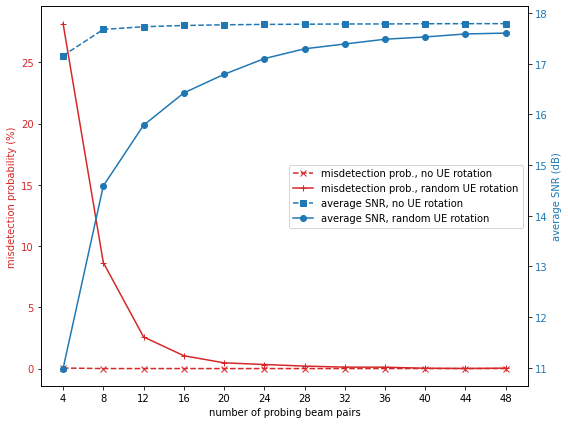

In [58]:
fig, ax1 = plt.subplots(figsize=(8,6))
color = 'tab:red'
ax1.set_xlabel('number of probing beam pairs')
ax1.set_ylabel('misdetection probability (%)', color=color)
lns1=ax1.plot(n_pb_arr, misdetection_rate_vs_npb_no_rotation, color=color, linestyle='dashed', marker='x',label='misdetection prob., no UE rotation')
lns2=ax1.plot(n_pb_arr, misdetection_rate_vs_npb_dict['GF_MLP_TxRx_diagonal_None_0.3'], color=color, marker='+',label='misdetection prob., random UE rotation')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xticks(n_pb_arr)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('average SNR (dB)', color=color)  
lns3=ax2.plot(n_pb_arr, pow_2_dB(dB_2_pow(snr_vs_npb_no_rotation).mean(axis=-1)), color=color, linestyle='dashed', marker='s',label='average SNR, no UE rotation')
lns4=ax2.plot(n_pb_arr, pow_2_dB(dB_2_pow(snr_vs_npb_dict['GF_MLP_TxRx_diagonal_None_0.3']).mean(axis=-1)), color=color, marker='o',label='average SNR, random UE rotation')
ax2.tick_params(axis='y', labelcolor=color)

lns = lns1+lns2+lns3+lns4
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc='center right')

fig.tight_layout()
plt.show()